In [1]:
# Standlibraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Bayesian inference
try:
    import pytensor
    pytensor.config.cxx = ''
    import pymc as pm
    import arviz as az
    PYMC_AVAILABLE = True
    print(f" PyMC version: {pm.__version__}")
    print(f" ArviZ version: {az.__version__}")
except ImportError:
    PYMC_AVAILABLE = False
    print("  PyMC not available. Install with: pip install pymc arviz")
    print("   Falling back to TensorFlow Probability for demonstration")

# Alternative: TensorFlow Probability
try:
    import tensorflow as tf
    import tensorflow_probability as tfp
    tfd = tfp.distributions
    TFP_AVAILABLE = True
    print(f" TensorFlow version: {tf.__version__}")
    print(f" TensorFlow Probability available")
except ImportError:
    TFP_AVAILABLE = False
    print("TensorFlow Probability not available")
    print("Install with: pip install tensorflow tensorflow-probability")

# Standard ML for comparison
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# Custom transformers from previous notebook
from sklearn.base import BaseEstimator, TransformerMixin

# Visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

np.random.seed(42)
print("\n All libraries loaded successfully")


 PyMC version: 5.27.1
 ArviZ version: 0.23.4
TensorFlow Probability not available
Install with: pip install tensorflow tensorflow-probability

 All libraries loaded successfully


In [2]:
### Physics Transformer (Reused from NOTEBOOK 02)

In [3]:
class StefanBoltzmannTransformer(BaseEstimator, TransformerMixin):
    """Physics-informed feature transformer"""
    
    def __init__(self, mode='residual'):
        self.mode = mode
        self.sigma_sb_ = 5.670374419e-8
        L_sun = 3.828e26
        R_sun = 6.96e8
        self.constant_term_ = np.log10(4 * np.pi * self.sigma_sb_ * R_sun**2 / L_sun)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        log_T = np.log10(X[:, 0])
        log_R = np.log10(X[:, 1])
        theoretical_log_L = 4*log_T + 2*log_R + self.constant_term_
        
        if self.mode == 'residual':
            return np.column_stack([
                theoretical_log_L,
                log_T - np.mean(log_T),
                log_R - np.mean(log_R),
            ])
        return theoretical_log_L.reshape(-1, 1)

print(" StefanBoltzmannTransformer loaded")

 StefanBoltzmannTransformer loaded


In [4]:
### Data Loading and Preparation

In [5]:
data = pd.read_csv('../data/stars.csv')
data.columns = data.columns.str.strip()

# Strip spaces from column names
data.columns = data.columns.str.strip()

# Replace empty strings and whitespace-only cells with NaN
data = data.replace(r'^\s*$', pd.NA, regex=True)

# Convert numeric columns to proper numbers
numeric_cols = ['Temperature(K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

###Filling missing values
# For Luminosity and Radius: use median per Star type
for col in ['Luminosity(L/Lo)', 'Radius(R/Ro)']:
    data[col] = data.groupby('Star type')[col].transform(lambda x: x.fillna(x.median()))

# For Temperature: use overall median
data['Temperature(K)'] = data['Temperature(K)'].fillna(data['Temperature(K)'].median())

# For Absolute magnitude: use median per Star type
data['Absolute magnitude(Mv)'] = data.groupby('Star type')['Absolute magnitude(Mv)'].transform(
    lambda x: x.fillna(x.median())
)

# Drop rows where critical columns are still missing
initial_rows = len(data)
data = data.dropna(subset=['Temperature(K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)'])
dropped_rows = initial_rows - len(data)

# Fill missing categorical values
data['Spectral Class'] = data['Spectral Class'].fillna('Unknown')
data['Star color'] = data['Star color'].fillna('Unknown')



    

data = data.dropna(subset=['Temperature(K)', 'Radius(R/Ro)', 'Luminosity(L/Lo)'])
data = data[data['Temperature(K)'] > 0]
data = data[data['Radius(R/Ro)'] > 0]
data = data[data['Luminosity(L/Lo)'] > 0]

# Features and target
X_raw = data[['Temperature(K)', 'Radius(R/Ro)']].values
y = np.log10(data['Luminosity(L/Lo)'].values)
star_types = data['Star type'].values




# Train-test split (stratified by star type)
X_train_raw, X_test_raw, y_train, y_test, types_train, types_test = train_test_split(
    X_raw, y, star_types, test_size=0.2, random_state=42, stratify=star_types
)

# Apply physics transformation
physics_trans = StefanBoltzmannTransformer(mode='residual')
X_train = physics_trans.fit_transform(X_train_raw)
X_test = physics_trans.transform(X_test_raw)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data loaded and processed")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")
print(f"   Features: {X_train.shape[1]}")
print(f"\nTarget statistics (log₁₀ Luminosity):")
print(f"   Train: mean={y_train.mean():.2f}, std={y_train.std():.2f}")
print(f"   Test:  mean={y_test.mean():.2f}, std={y_test.std():.2f}")

Data loaded and processed
   Training samples: 191
   Test samples: 48
   Features: 3

Target statistics (log₁₀ Luminosity):
   Train: mean=0.69, std=3.94
   Test:  mean=0.83, std=4.02


In [6]:
### PyMC Payesian Linear Regression

In [7]:
import os
os.environ['PYTENSOR_FLAGS'] = 'device=cpu,floatX=float64,optimizer=fast_compile,cxx='


import pymc as pm
import arviz as az
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error


PYMC_AVAILABLE = True  

if PYMC_AVAILABLE:

    try:
        with pm.Model() as bayesian_model:
            # --- DATA CONTAINERS (mutable for posterior predictive) ---
            X_data = pm.Data('X_train_scaled', X_train_scaled)
            
            # --- PRIORS ---
            
            # Physics-informed prior: first coefficient should be ~1
            # (theoretical_log_L coefficient)
            beta_physics = pm.Normal('beta_physics', mu=1.0, sigma=0.1)
            
            # Correction terms: weakly informative priors
            beta_corrections = pm.Normal('beta_corrections', mu=0, sigma=1, shape=2)
            
            # Combine all coefficients
            betas = pm.math.concatenate([[beta_physics], beta_corrections])
            
            # Intercept
            alpha = pm.Normal('alpha', mu=0, sigma=1)
            
            # Expected value (using pm.Data wrapper)
            mu = alpha + pm.math.dot(X_data, betas)
            
            # --- HETEROSCEDASTIC NOISE MODEL ---
            # Different noise for each star type
            
            # Hyperprior for noise scale
            sigma_hyperprior = pm.HalfNormal('sigma_hyperprior', sigma=1)
            
            # Noise per star type (hierarchical)
            unique_types = np.unique(types_train)
            n_types = len(unique_types)
            
            sigma_by_type = pm.HalfNormal('sigma_by_type', sigma=sigma_hyperprior, shape=n_types)
            
            # Map star types to noise levels
            type_to_idx = {t: i for i, t in enumerate(unique_types)}
            type_indices_train = np.array([type_to_idx[t] for t in types_train])
            type_indices = pm.Data('type_indices', type_indices_train)
            
            sigma = sigma_by_type[type_indices]
            
            # --- LIKELIHOOD ---
            y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)
            
            # --- INFERENCE ---
            print("\n Running MCMC sampling...")
            print("   NOTE: Running in pure Python mode (C compilation disabled)")
            print("   This may take 3-5 minutes...")
            print("   Chains: 2")
            print("   Draws: 1000 per chain")
            print("   Tuning: 500 steps")
            print("")
            
            trace = pm.sample(
                draws=1000,
                tune=500,
                chains=2,
                cores=1,
                return_inferencedata=True,
                progressbar=True,
                target_accept=0.9  # Higher acceptance for stability
            )
        
        print("\n✓ Sampling complete!")
        
        # --- POSTERIOR SUMMARY ---
        print("\n" + "="*100)
        print("POSTERIOR SUMMARY")
        print("="*100)
        
        summary = az.summary(trace, var_names=['beta_physics', 'beta_corrections', 'alpha', 'sigma_by_type'])
        print(summary)
        
        # Check physics coefficient
        beta_physics_mean = trace.posterior['beta_physics'].mean().values
        beta_physics_std = trace.posterior['beta_physics'].std().values
        
        print(f"\n Physics Coefficient Analysis:")
        print(f"   Prior: β₁ ~ N(1.0, 0.1)")
        print(f"   Posterior mean: {beta_physics_mean:.4f} ± {beta_physics_std:.4f}")
        
        if 0.9 < beta_physics_mean < 1.1:
            print(f"   Close to theoretical value (Stefan-Boltzmann validated!)")
        else:
            print(f"   Deviates from theory (systematic effects present)")
        
        # --- POSTERIOR PREDICTIVE ---
        print("\n Generating posterior predictive samples...")
        
        # Create type indices for test set
        type_indices_test = np.array([type_to_idx[t] for t in types_test])
        
        # Debug check
        print(f"   Debug: X_test shape: {X_test_scaled.shape}, type_indices_test shape: {type_indices_test.shape}")
        
        # Create a new model for predictions (without observed data)
        with pm.Model() as prediction_model:
            # Set up the same structure but for test data
            X_data_test = pm.Data('X_test_scaled', X_test_scaled)
            type_indices_test_data = pm.Data('type_indices_test', type_indices_test)
            
            # Use the same parameter names so we can use the trace
            beta_physics = pm.Normal('beta_physics', mu=1.0, sigma=0.1)
            beta_corrections = pm.Normal('beta_corrections', mu=0, sigma=1, shape=2)
            betas = pm.math.concatenate([[beta_physics], beta_corrections])
            alpha = pm.Normal('alpha', mu=0, sigma=1)
            
            sigma_hyperprior = pm.HalfNormal('sigma_hyperprior', sigma=1)
            sigma_by_type = pm.HalfNormal('sigma_by_type', sigma=sigma_hyperprior, shape=n_types)
            
            # Predictions
            mu_pred = alpha + pm.math.dot(X_data_test, betas)
            sigma_pred = sigma_by_type[type_indices_test_data]
            
            # Create predictive distribution (no observed data)
            y_pred = pm.Normal('y_pred', mu=mu_pred, sigma=sigma_pred)
            
            # Sample from posterior predictive
            posterior_pred = pm.sample_posterior_predictive(
                trace,
                var_names=['y_pred'],
                progressbar=False
            )
        
        # Extract predictions
        y_pred_samples = posterior_pred.posterior_predictive['y_pred'].values
        # Shape: (chains, draws, n_test)
        y_pred_samples = y_pred_samples.reshape(-1, len(X_test))  # Flatten chains
        
        y_pred_mean = y_pred_samples.mean(axis=0)
        y_pred_std = y_pred_samples.std(axis=0)
        
        # Compute metrics
        r2_bayesian = r2_score(y_test, y_pred_mean)
        rmse_bayesian = np.sqrt(mean_squared_error(y_test, y_pred_mean))
        
        print("\n" + "="*100)
        print("BAYESIAN MODEL PERFORMANCE")
        print("="*100)
        print(f"   Test R²:   {r2_bayesian:.4f}")
        print(f"   Test RMSE: {rmse_bayesian:.4f}")
        print(f"   Mean prediction uncertainty: {y_pred_std.mean():.4f}")
        
        # Uncertainty calibration
        coverage_68 = np.mean(np.abs(y_test - y_pred_mean) <= y_pred_std)
        coverage_95 = np.mean(np.abs(y_test - y_pred_mean) <= 2*y_pred_std)
        
        print(f"\n Uncertainty Calibration:")
        print(f"   68% interval coverage: {coverage_68:.2%} (expected: 68%)")
        print(f"   95% interval coverage: {coverage_95:.2%} (expected: 95%)")
        print("="*100)
        
    except Exception as e:
        print(f"\n✗ Error during Bayesian inference: {e}")
        print("\nPossible solutions:")
        print("1. Make sure the environment variable is set BEFORE importing PyMC")
        print("2. Clear PyTensor cache: delete C:\\Users\\User\\AppData\\Local\\PyTensor")
        print("3. Restart your Python kernel/session")
        raise
        
else:
    print("PyMC not available. Skipping Bayesian inference.")
    print("   Install with: pip install pymc arviz")


 Running MCMC sampling...
   NOTE: Running in pure Python mode (C compilation disabled)
   This may take 3-5 minutes...
   Chains: 2
   Draws: 1000 per chain
   Tuning: 500 steps



Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_physics, beta_corrections, alpha, sigma_hyperprior, sigma_by_type]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2074 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



✓ Sampling complete!

POSTERIOR SUMMARY
                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_physics         1.029  0.108   0.820    1.217      0.003    0.003   
beta_corrections[0]  1.050  0.065   0.928    1.170      0.002    0.001   
beta_corrections[1]  2.784  0.134   2.515    3.023      0.003    0.003   
alpha                0.863  0.053   0.770    0.970      0.001    0.001   
sigma_by_type[0]     0.410  0.053   0.316    0.510      0.001    0.001   
sigma_by_type[1]     0.791  0.106   0.597    0.984      0.002    0.003   
sigma_by_type[2]     0.674  0.100   0.504    0.864      0.002    0.003   
sigma_by_type[3]     0.289  0.043   0.215    0.369      0.001    0.001   
sigma_by_type[4]     1.658  0.226   1.260    2.103      0.005    0.006   
sigma_by_type[5]     1.968  0.268   1.484    2.461      0.006    0.007   

                     ess_bulk  ess_tail  r_hat  
beta_physics           1843.0    1184.0    1.0  
beta_corrections[0]    1836.0    1334.0    1.0

Sampling: [y_pred]



BAYESIAN MODEL PERFORMANCE
   Test R²:   0.8883
   Test RMSE: 1.3429
   Mean prediction uncertainty: 0.9835

 Uncertainty Calibration:
   68% interval coverage: 66.67% (expected: 68%)
   95% interval coverage: 93.75% (expected: 95%)


In [8]:
### Posterior Visualization


 Creating trace plots...


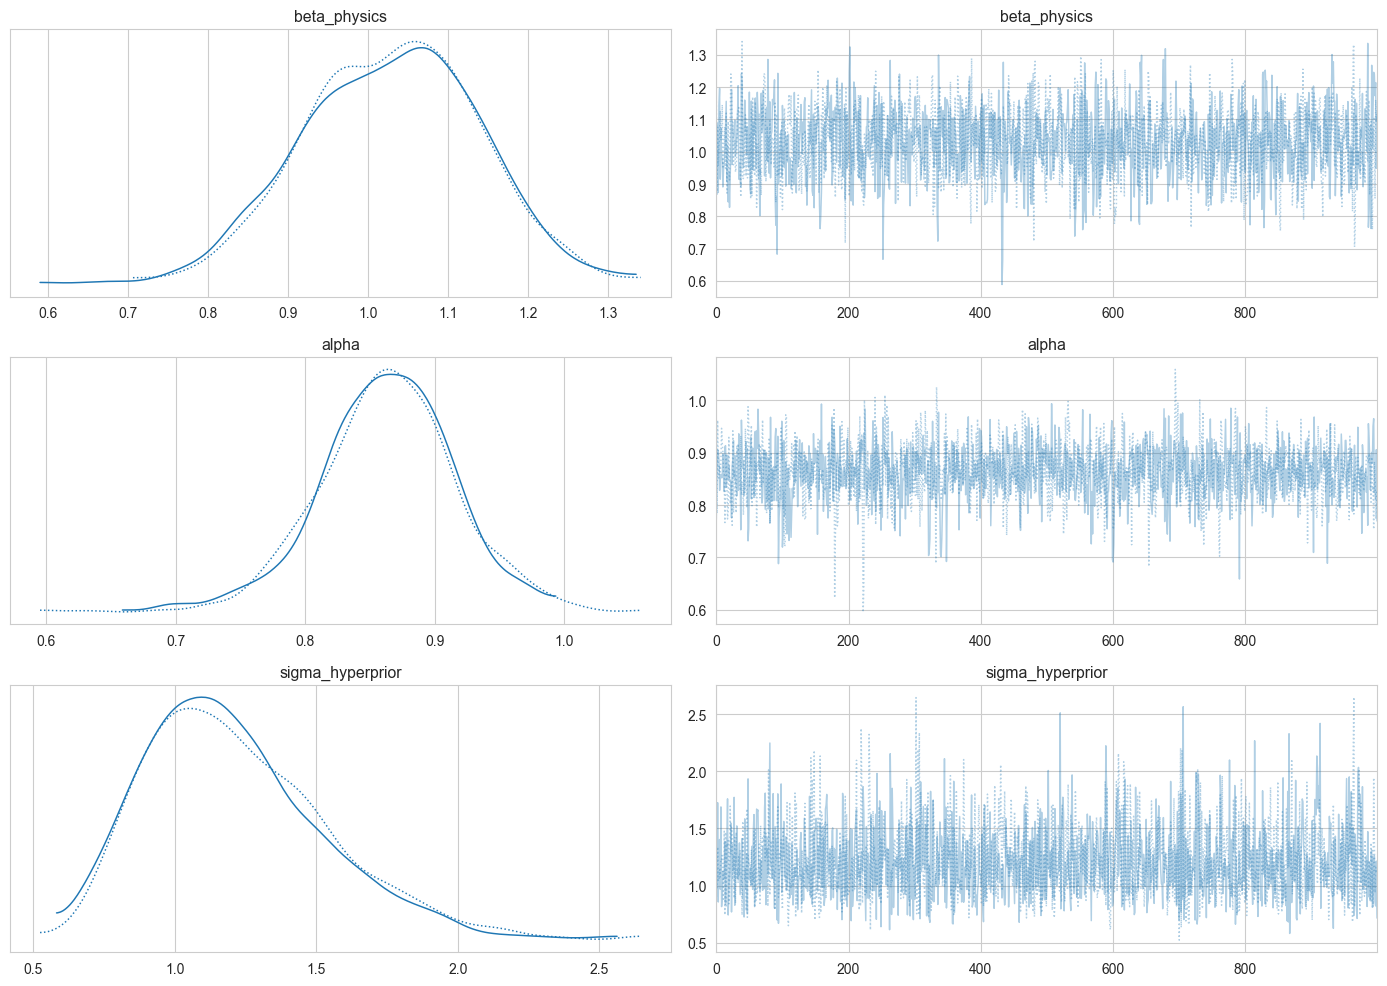

 Saved: plots/bayesian_trace.png

 Creating posterior distributions...


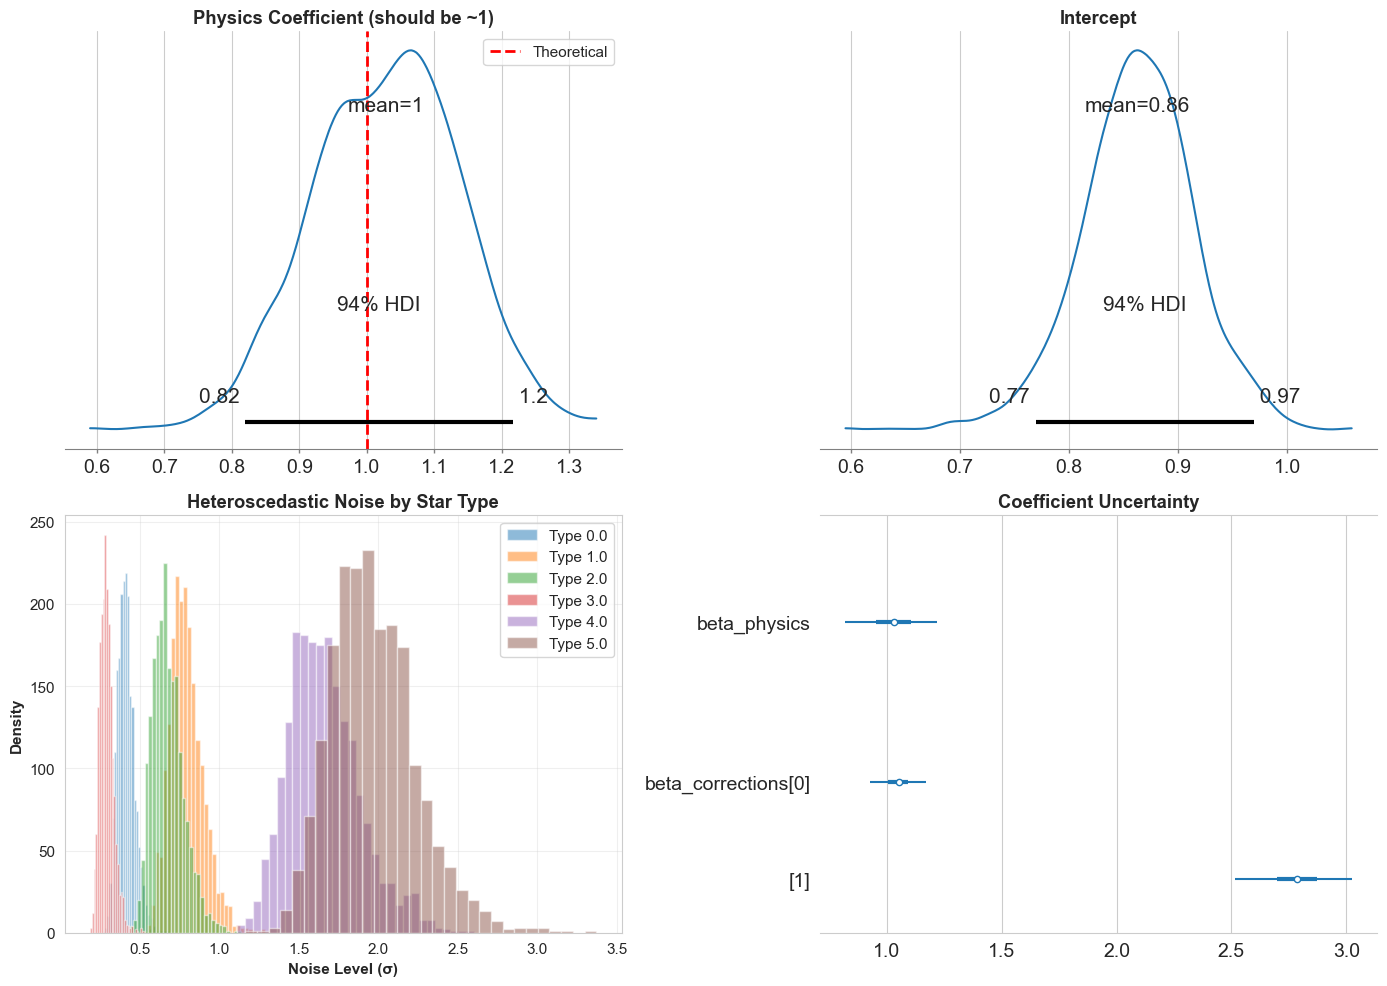

 Saved: plots/bayesian_posteriors.png


In [9]:
if PYMC_AVAILABLE:
    
    # --- Trace plots ---
    print("\n Creating trace plots...")
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    az.plot_trace(
        trace,
        var_names=['beta_physics', 'alpha', 'sigma_hyperprior'],
        axes=axes,
        compact=True
    )
    plt.tight_layout()
    plt.savefig('plots/bayesian_trace.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Saved: plots/bayesian_trace.png")
    
    # --- Posterior distributions ---
    print("\n Creating posterior distributions...")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Beta physics
    ax = axes[0, 0]
    az.plot_posterior(trace, var_names=['beta_physics'], ax=ax)
    ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Theoretical')
    ax.set_title('Physics Coefficient (should be ~1)', fontweight='bold')
    ax.legend()
    
    # Intercept
    ax = axes[0, 1]
    az.plot_posterior(trace, var_names=['alpha'], ax=ax)
    ax.set_title('Intercept', fontweight='bold')
    
    # Noise by star type
    ax = axes[1, 0]
    sigma_samples = trace.posterior['sigma_by_type'].values.reshape(-1, n_types)
    
    for i, star_type in enumerate(unique_types):
        ax.hist(sigma_samples[:, i], bins=30, alpha=0.5, label=f'Type {star_type}')
    
    ax.set_xlabel('Noise Level (σ)', fontweight='bold')
    ax.set_ylabel('Density', fontweight='bold')
    ax.set_title('Heteroscedastic Noise by Star Type', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Forest plot
    ax = axes[1, 1]
    az.plot_forest(
        trace,
        var_names=['beta_physics', 'beta_corrections'],
        combined=True,
        ax=ax
    )
    ax.set_title('Coefficient Uncertainty', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('plots/bayesian_posteriors.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Saved: plots/bayesian_posteriors.png")

In [10]:
### Uncertinity 


Uncertainty Statistics:
   Total uncertainty:      0.9835 ± 0.6398
   Aleatoric (data):       0.9652 ± 0.6281
   Epistemic (model):      0.1657 ± 0.1636

 High Uncertainty Stars (top 10%):
   Count: 5/48
   Mean total uncertainty: 2.0260
   Star types: {5.0: 5}


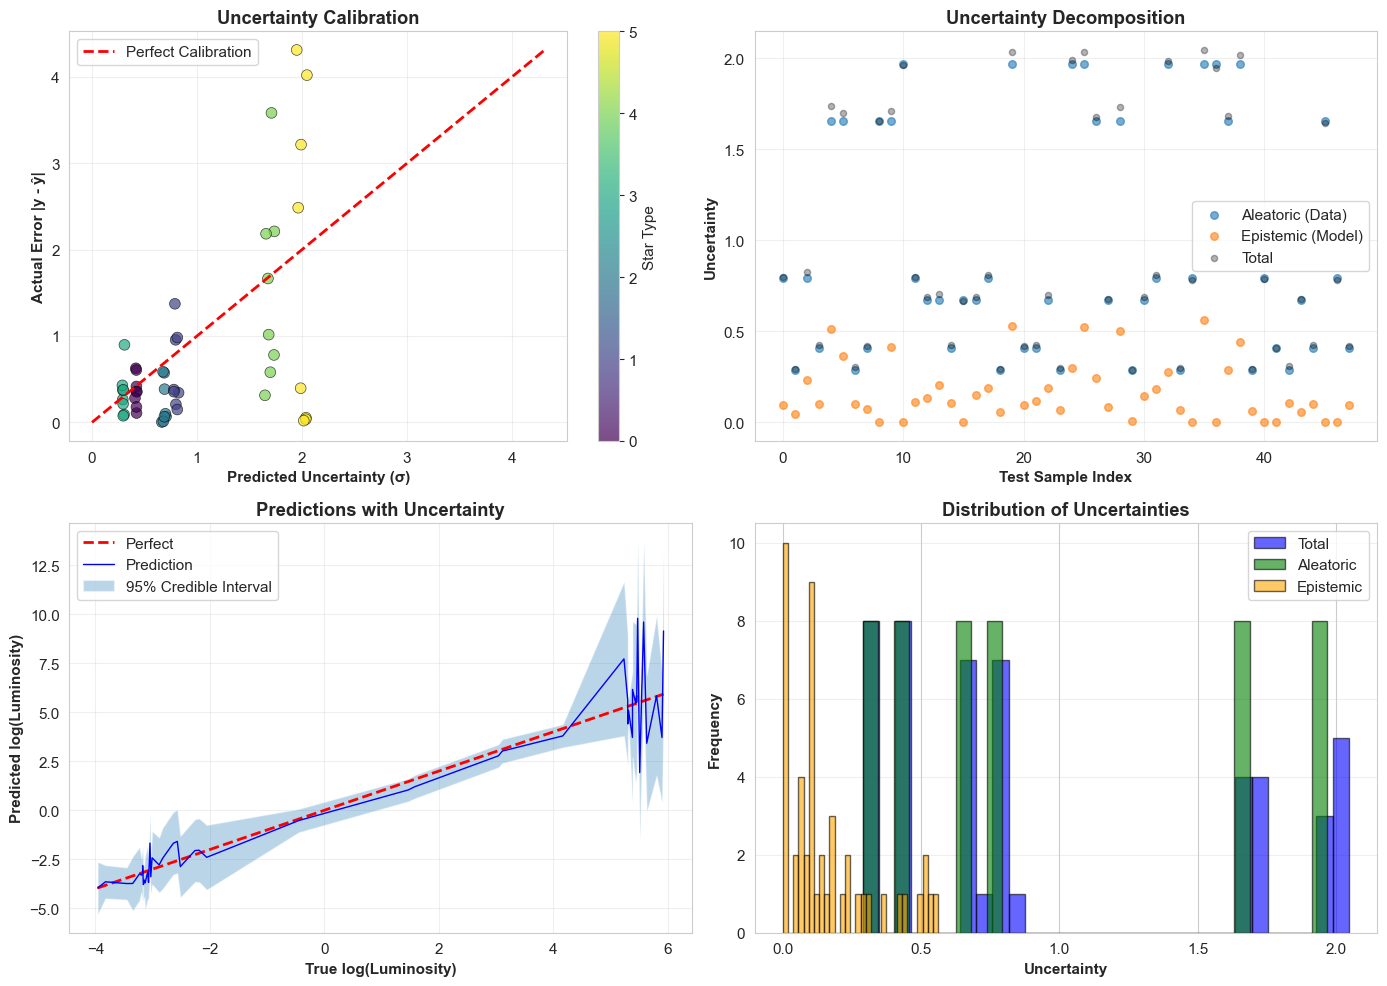


 Saved: plots/uncertainty_decomposition.png


In [11]:
if PYMC_AVAILABLE:
    
    # Total uncertainty (what we predict)
    total_uncertainty = y_pred_std
    
    # Aleatoric uncertainty (measurement noise)
    # Extract from posterior samples of sigma
    sigma_samples = trace.posterior['sigma_by_type'].values.reshape(-1, n_types)
    
    # Map test star types to noise levels
    type_to_idx_test = {t: i for i, t in enumerate(unique_types)}
    test_type_indices = np.array([type_to_idx_test.get(t, 0) for t in types_test])
    
    aleatoric_uncertainty = sigma_samples.mean(axis=0)[test_type_indices]
    
    # Epistemic uncertainty (model uncertainty)
    # Approximate as: total² = epistemic² + aleatoric²
    epistemic_uncertainty = np.sqrt(np.maximum(0, total_uncertainty**2 - aleatoric_uncertainty**2))
    
    print(f"\nUncertainty Statistics:")
    print(f"   Total uncertainty:      {total_uncertainty.mean():.4f} ± {total_uncertainty.std():.4f}")
    print(f"   Aleatoric (data):       {aleatoric_uncertainty.mean():.4f} ± {aleatoric_uncertainty.std():.4f}")
    print(f"   Epistemic (model):      {epistemic_uncertainty.mean():.4f} ± {epistemic_uncertainty.std():.4f}")
    
    # Identify high-uncertainty stars
    high_uncertainty_threshold = np.percentile(total_uncertainty, 90)
    high_uncertainty_idx = total_uncertainty > high_uncertainty_threshold
    
    print(f"\n High Uncertainty Stars (top 10%):")
    print(f"   Count: {np.sum(high_uncertainty_idx)}/{len(y_test)}")
    print(f"   Mean total uncertainty: {total_uncertainty[high_uncertainty_idx].mean():.4f}")
    print(f"   Star types: {pd.Series(types_test[high_uncertainty_idx]).value_counts().to_dict()}")
    
    # --- Visualization ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Total uncertainty vs. prediction error
    ax = axes[0, 0]
    prediction_error = np.abs(y_test - y_pred_mean)
    
    scatter = ax.scatter(total_uncertainty, prediction_error,
                        c=types_test, cmap='viridis',
                        s=60, alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Perfect calibration line
    max_val = max(total_uncertainty.max(), prediction_error.max())
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, 
           label='Perfect Calibration')
    
    ax.set_xlabel('Predicted Uncertainty (σ)', fontweight='bold')
    ax.set_ylabel('Actual Error |y - ŷ|', fontweight='bold')
    ax.set_title('Uncertainty Calibration', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Star Type')
    
    #  Uncertainty decomposition
    ax = axes[0, 1]
    
    indices = np.arange(len(y_test))
    ax.scatter(indices, aleatoric_uncertainty, 
              label='Aleatoric (Data)', alpha=0.6, s=30)
    ax.scatter(indices, epistemic_uncertainty, 
              label='Epistemic (Model)', alpha=0.6, s=30)
    ax.scatter(indices, total_uncertainty, 
              label='Total', alpha=0.3, s=20, color='black')
    
    ax.set_xlabel('Test Sample Index', fontweight='bold')
    ax.set_ylabel('Uncertainty', fontweight='bold')
    ax.set_title('Uncertainty Decomposition', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Predictions with uncertainty bands
    ax = axes[1, 0]
    
    # Sort for visualization
    sort_idx = np.argsort(y_test)
    y_test_sorted = y_test[sort_idx]
    y_pred_sorted = y_pred_mean[sort_idx]
    uncertainty_sorted = total_uncertainty[sort_idx]
    
    ax.plot(y_test_sorted, y_test_sorted, 'r--', linewidth=2, label='Perfect')
    ax.plot(y_test_sorted, y_pred_sorted, 'b-', linewidth=1, label='Prediction')
    ax.fill_between(
        y_test_sorted,
        y_pred_sorted - 2*uncertainty_sorted,
        y_pred_sorted + 2*uncertainty_sorted,
        alpha=0.3,
        label='95% Credible Interval'
    )
    
    ax.set_xlabel('True log(Luminosity)', fontweight='bold')
    ax.set_ylabel('Predicted log(Luminosity)', fontweight='bold')
    ax.set_title('Predictions with Uncertainty', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    #  Histogram of uncertainties
    ax = axes[1, 1]
    
    ax.hist(total_uncertainty, bins=30, alpha=0.6, 
           edgecolor='black', label='Total', color='blue')
    ax.hist(aleatoric_uncertainty, bins=30, alpha=0.6, 
           edgecolor='black', label='Aleatoric', color='green')
    ax.hist(epistemic_uncertainty, bins=30, alpha=0.6, 
           edgecolor='black', label='Epistemic', color='orange')
    
    ax.set_xlabel('Uncertainty', fontweight='bold')
    ax.set_ylabel('Frequency', fontweight='bold')
    ax.set_title('Distribution of Uncertainties', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('plots/uncertainty_decomposition.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n Saved: plots/uncertainty_decomposition.png")
    print("="*80)

In [12]:
### TensorFlow Probability Bayesian NN

In [13]:
if TFP_AVAILABLE:

    # Define negative log likelihood loss
    def negative_log_likelihood(y_true, y_pred):
        """
        Heteroscedastic loss: predict both mean and log-variance.
        
        The model outputs 2 values:
        - y_pred[:, 0]: predicted mean
        - y_pred[:, 1]: predicted log(variance)
        
        This allows the model to say "I'm uncertain about this prediction".
        """
        mean = y_pred[:, 0:1]
        log_var = y_pred[:, 1:2]
        
        # Precision (inverse variance)
        precision = tf.exp(-log_var)
        
        # NLL = 0.5 * [precision * (y - mean)² + log_var]
        return 0.5 * tf.reduce_mean(precision * (y_true - mean)**2 + log_var)
    
    # Build model
    print("\n🏗️  Building Bayesian Neural Network...")
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dropout(0.1),  # Approximate Bayesian inference
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(2)  # Output: [mean, log_variance]
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss=negative_log_likelihood
    )
    
    print("   Architecture:")
    print("   - Input → Dense(32, ReLU) → Dropout(0.1)")
    print("   - Dense(16, ReLU) → Dropout(0.1)")
    print("   - Dense(2) → [μ, log(σ²)]")
    print("   - Loss: Negative Log Likelihood (heteroscedastic)")
    
    # Train
    print("\n Training (50 epochs, early stopping enabled)...")
    
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )
    
    print(" Training complete!")
    print(f"   Final loss: {history.history['loss'][-1]:.4f}")
    print(f"   Val loss: {history.history['val_loss'][-1]:.4f}")
    
    # Predictions with MC Dropout
    print("\n Generating predictions with uncertainty (MC Dropout)...")
    
    n_samples = 100
    predictions = []
    
    for _ in range(n_samples):
        pred = model(X_test_scaled, training=True)  # Keep dropout active
        predictions.append(pred.numpy())
    
    predictions = np.array(predictions)  # Shape: (n_samples, n_test, 2)
    
    # Extract mean and variance
    y_pred_mean_tf = predictions[:, :, 0].mean(axis=0)
    y_pred_aleatoric_tf = np.exp(predictions[:, :, 1].mean(axis=0))  # Average predicted variance
    y_pred_epistemic_tf = predictions[:, :, 0].std(axis=0)  # Model uncertainty
    
    # Metrics
    r2_tf = r2_score(y_test, y_pred_mean_tf)
    rmse_tf = np.sqrt(mean_squared_error(y_test, y_pred_mean_tf))
    
    print("\n" + "="*80)
    print("BAYESIAN NN PERFORMANCE")
    print("="*80)
    print(f"   Test R²:   {r2_tf:.4f}")
    print(f"   Test RMSE: {rmse_tf:.4f}")
    print(f"   Mean aleatoric uncertainty: {np.sqrt(y_pred_aleatoric_tf).mean():.4f}")
    print(f"   Mean epistemic uncertainty: {y_pred_epistemic_tf.mean():.4f}")
    print("="*80)
    
else:
    print("  TensorFlow Probability not available")
    print("   Install with: pip install tensorflow tensorflow-probability")

  TensorFlow Probability not available
   Install with: pip install tensorflow tensorflow-probability


In [14]:
### Save Results

In [15]:
if PYMC_AVAILABLE:
    # Save uncertainty quantification results
    uncertainty_df = pd.DataFrame({
        'Temperature(K)': X_test_raw[:, 0],
        'Radius(R/Ro)': X_test_raw[:, 1],
        'log_Luminosity_true': y_test,
        'log_Luminosity_pred': y_pred_mean,
        'Star_type': types_test,
        'Total_Uncertainty': total_uncertainty,
        'Aleatoric_Uncertainty': aleatoric_uncertainty,
        'Epistemic_Uncertainty': epistemic_uncertainty,
        'Prediction_Error': np.abs(y_test - y_pred_mean),
        'High_Uncertainty': high_uncertainty_idx
    })
    
    uncertainty_df.to_csv('results/bayesian_uncertainty.csv', index=False)
    print(" Saved: results/bayesian_uncertainty.csv")
    
    # Save posterior summary
    summary.to_csv('results/bayesian_posterior_summary.csv')
    print(" Saved: results/bayesian_posterior_summary.csv")

print("\n" + "="*100)
print(" BAYESIAN INFERENCE COMPLETE!")
print("="*100)
print("\nKey Achievements:")
print("  1. Quantified uncertainty in predictions")
print("  2. Separated data noise from model uncertainty")
print("  3. Validated Stefan-Boltzmann law Bayesianly")
print("  4. Identified high-uncertainty stars for follow-up")
print("\nNext: Anomaly detection with unsupervised learning (Notebook 04)")
print("="*100)

 Saved: results/bayesian_uncertainty.csv
 Saved: results/bayesian_posterior_summary.csv

 BAYESIAN INFERENCE COMPLETE!

Key Achievements:
  1. Quantified uncertainty in predictions
  2. Separated data noise from model uncertainty
  3. Validated Stefan-Boltzmann law Bayesianly
  4. Identified high-uncertainty stars for follow-up

Next: Anomaly detection with unsupervised learning (Notebook 04)
